In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="darkgrid")

In [2]:
df = pd.read_csv('data/RocketsTeamStats.csv')

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [4]:
df['W/L'].map(dict(W=1, N=0))


feature_names = ['FG', 'FGA', '3P', '3PA', 'FTA','ORB','TRB','AST','STL','BLK','TOV','PF',
                'OFG', 'OFGA', 'O3P', 'O3PA', 'OFTA','OORB','OTRB','OAST','OSTL','OBLK','OTOV','OPF']

X=df[feature_names]
y = df['W/L']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['W/L'], random_state=0)

In [6]:
names = []
scores = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name  Score
0  KNN  0.750
1  SVC  0.500
2   LR  0.750
3   DT  0.875
4  GNB  0.750
5   RF  0.375
6   GB  0.875


In [7]:
strat_k_fold = StratifiedKFold(n_splits=10, random_state=10)

names = []
scores = []
for name, model in models:
    
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, X, y, cv=strat_k_fold, scoring='accuracy').mean()
    
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

  Name     Score
0  KNN  0.866667
1  SVC  0.533333
2   LR  0.825000
3   DT  0.808333
4  GNB  0.758333
5   RF  0.725000
6   GB  0.833333


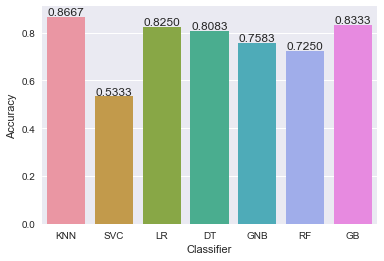

In [8]:
axis = sns.barplot(x = 'Name', y = 'Score', data = kf_cross_val)
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

In [9]:
from sklearn.feature_selection import RFECV
logreg_model = LogisticRegression(solver='lbfgs', max_iter=4000)

rfecv = RFECV(estimator=logreg_model, step=1, cv=strat_k_fold, scoring='accuracy')
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=False),
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=4000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

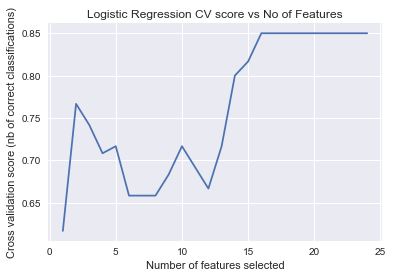

In [10]:
plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [11]:
feature_importance = list(zip(feature_names, rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
        
print(new_features)

['FG', 'FGA', '3P', '3PA', 'FTA', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'OFG', 'OFGA', 'O3P', 'O3PA', 'OFTA', 'OORB', 'OTRB', 'OAST', 'OSTL', 'OBLK', 'OTOV', 'OPF']


In [12]:
# Calculate accuracy scores 
X_new = df[new_features]

initial_score = cross_val_score(logreg_model, X, y, cv=strat_k_fold, scoring='accuracy').mean()
print("Initial accuracy : {} ".format(initial_score))

fe_score = cross_val_score(logreg_model, X_new, y, cv=strat_k_fold, scoring='accuracy').mean()
print("Accuracy after Feature Selection : {} ".format(fe_score))

Initial accuracy : 0.85 
Accuracy after Feature Selection : 0.85 


In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
# Specify parameters
c_values = list(np.arange(1, 10))
param_grid = [
    {'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': c_values, 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}
]

In [15]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=strat_k_fold, scoring='accuracy', iid=False)
grid.fit(X_new, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=False),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=1,
       param_grid=[{'C': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'penalty': ['l1'], 'solver': ['liblinear'], 'multi_class': ['ovr']}, {'C': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'penalty': ['l2'], 'solver': ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class': ['ovr']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [16]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)


In [17]:
logreg_new = LogisticRegression(C=1, multi_class='ovr', penalty='l2', solver='liblinear')

In [18]:
initial_score = cross_val_score(logreg_new, X_new, y, cv=strat_k_fold, scoring='accuracy').mean()
print("Final accuracy : {} ".format(initial_score))

Final accuracy : 0.825 


In [19]:
logreg_new.fit(X_new, y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
d = {'FG': [44],
     'FGA': [96],
     '3P': [16],
     '3PA':[45],
     'FTA': [42],
     'ORB': [30],
     'TRB': [13],
     'AST': [54],
     'STL': [22],
     'BLK': [3],
     'TOV': [13],
     'PF': [23],
     'OFG': [32],
     'OFGA': [90],
     'O3P': [13],
     'O3PA':[45],
     'OFTA': [13],
     'OORB': [13],
     'OTRB': [13],
     'OAST': [23],
     'OSTL': [3],
     'OBLK': [3],
     'OTOV': [15],
     'OPF': [28]
    }
predictionFrame = pd.DataFrame(data=d)


In [21]:
X_new.loc[[1]]
grid.predict(X_new.loc[[6]])

array(['W'], dtype=object)